<a href="https://colab.research.google.com/github/EldarsUP/Machine_1/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [3]:
# Загрузка набора данных
df = pd.read_csv('/content/insurance.csv')

In [4]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [7]:
df['old'] = np.where(df['age'] >= 40, 1, 0).astype(int)
df.old = df.old.astype('category')
df.sex= df.sex.astype('category')
df.smoker= df.smoker.astype('category')
df.region=df.region.astype('category')

In [8]:
Y = df['old'] # выбираем целевую переменную (категориальную)
X = df.drop('old', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('age', axis=1)

In [9]:
df.drop('age', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sex       1338 non-null   category
 1   bmi       1338 non-null   float64 
 2   children  1338 non-null   int64   
 3   smoker    1338 non-null   category
 4   region    1338 non-null   category
 5   charges   1338 non-null   float64 
 6   old       1338 non-null   category
dtypes: category(4), float64(2), int64(1)
memory usage: 37.3 KB


In [10]:
df

,age,sex,bmi,children,smoker,region,charges,old
0,19,female,27.900,0,yes,southwest,16884.92400,0
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1
1334,18,female,31.920,0,no,northeast,2205.98080,0
1335,18,female,36.850,0,no,southeast,1629.83350,0
1336,21,female,25.800,0,no,southwest,2007.94500,0


## 2: масштабирование признаков

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sex       1338 non-null   category
 1   bmi       1338 non-null   float64 
 2   children  1338 non-null   int64   
 3   smoker    1338 non-null   category
 4   region    1338 non-null   category
 5   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(1)
memory usage: 35.8 KB


In [12]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [13]:
X_processed

,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,27.900,0,16884.92400,False,True,False,False,True
1,33.770,1,1725.55230,True,False,False,True,False
2,33.000,3,4449.46200,True,False,False,True,False
3,22.705,0,21984.47061,True,False,True,False,False
4,28.880,0,3866.85520,True,False,True,False,False
...,...,...,...,...,...,...,...,...
1333,30.970,3,10600.54830,True,False,True,False,False
1334,31.920,0,2205.98080,False,False,False,False,False
1335,36.850,0,1629.83350,False,False,False,True,False
1336,25.800,0,2007.94500,False,False,False,False,True


In [14]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['float64','int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [15]:
X_processed

,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0.321227,0.0,0.251611,False,True,False,False,True
1,0.479150,0.2,0.009636,True,False,False,True,False
2,0.458434,0.6,0.053115,True,False,False,True,False
3,0.181464,0.0,0.333010,True,False,True,False,False
4,0.347592,0.0,0.043816,True,False,True,False,False
...,...,...,...,...,...,...,...,...
1333,0.403820,0.6,0.151299,True,False,True,False,False
1334,0.429379,0.0,0.017305,False,False,False,False,False
1335,0.562012,0.0,0.008108,False,False,False,True,False
1336,0.264730,0.0,0.014144,False,False,False,False,True


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [16]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [17]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.7776
Точность на тестовой выборке: 0.7761

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       135
           1       0.81      0.72      0.76       133

    accuracy                           0.78       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.78      0.78      0.78       268



LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [18]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [19]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [20]:
X_processed.describe()

,bmi,children,charges
count,1338.000000,1338.000000,1338.000000
mean,0.395572,0.218984,0.193916
std,0.164062,0.241099,0.193301
min,0.000000,0.000000,0.000000
25%,0.278080,0.000000,0.057757
50%,0.388485,0.200000,0.131849
75%,0.504002,0.400000,0.247700
max,1.000000,1.000000,1.000000


In [21]:
X_iqr.describe()

,bmi,children,charges
count,1332.000000,1332.000000,1332.000000
mean,0.394871,0.219369,0.190644
std,0.163803,0.241116,0.187420
min,0.000000,0.000000,0.000000
25%,0.276029,0.000000,0.057428
50%,0.385930,0.200000,0.130592
75%,0.501984,0.400000,0.244319
max,1.000000,1.000000,0.799263


In [22]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.6028
Точность на тестовой выборке: 0.5768

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.56      0.78      0.65       135
           1       0.62      0.37      0.46       132

    accuracy                           0.58       267
   macro avg       0.59      0.57      0.56       267
weighted avg       0.59      0.58      0.56       267



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

Убралось всего 6 значений, но все показатели значительно упали, наверное все таки потому что категориальных значений теперь нет, но возможно и потому что предыдущая модель сильно обращала внимание на "выбросы"

### Метод 2: удаление на основе среднего

In [23]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [24]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [25]:
X_processed.describe()

,bmi,children,charges
count,1338.000000,1338.000000,1338.000000
mean,0.395572,0.218984,0.193916
std,0.164062,0.241099,0.193301
min,0.000000,0.000000,0.000000
25%,0.278080,0.000000,0.057757
50%,0.388485,0.200000,0.131849
75%,0.504002,0.400000,0.247700
max,1.000000,1.000000,1.000000


In [26]:
X_mean.describe()

,bmi,children,charges
count,1142.000000,1142.000000,1142.000000
mean,0.377645,0.190718,0.153064
std,0.143777,0.210882,0.134193
min,0.068335,0.000000,0.000000
25%,0.268362,0.000000,0.052622
50%,0.373150,0.200000,0.118467
75%,0.477771,0.400000,0.199402
max,0.718859,0.600000,0.580422


In [27]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.6342
Точность на тестовой выборке: 0.6332

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68       118
           1       0.66      0.50      0.57       111

    accuracy                           0.63       229
   macro avg       0.64      0.63      0.63       229
weighted avg       0.64      0.63      0.63       229



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

В этот раз 10% данных было убрано, и показатели все равно упали, но уже не так сильно, что все таки свидетельствует о том, что дело в плохих граничных значениях, убрав которые можно получить лучшие показатели

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [28]:
from sklearn.feature_selection import SelectKBest, f_regression


In [76]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=4)
X_kbest = selector.fit_transform(X_processed, Y)


In [64]:
selector.scores_

array([1.27578456e+01, 9.05013381e-01, 9.61457283e+01, 3.57920688e-01,
       6.55005178e-01, 2.68257140e-02, 6.16975156e-03, 8.28713005e-03])

In [78]:
X_processed.columns

Index(['bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [79]:
X_processed

,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0.321227,0.0,0.251611,False,True,False,False,True
1,0.479150,0.2,0.009636,True,False,False,True,False
2,0.458434,0.6,0.053115,True,False,False,True,False
3,0.181464,0.0,0.333010,True,False,True,False,False
4,0.347592,0.0,0.043816,True,False,True,False,False
...,...,...,...,...,...,...,...,...
1333,0.403820,0.6,0.151299,True,False,True,False,False
1334,0.429379,0.0,0.017305,False,False,False,False,False
1335,0.562012,0.0,0.008108,False,False,False,True,False
1336,0.264730,0.0,0.014144,False,False,False,False,True


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [80]:
selector.get_support(indices=True)

array([0, 1, 2, 4])

In [81]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['bmi', 'children', 'charges', 'smoker_yes'], dtype='object')


In [82]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.7738
Точность на тестовой выборке: 0.7873

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       135
           1       0.82      0.74      0.77       133

    accuracy                           0.79       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.79      0.79      0.79       268



LogisticRegression(max_iter=1000)

Тут все показатели получились идентично оригиналу

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [83]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


Отобранные признаки: Index(['bmi', 'children', 'charges', 'sex_male', 'smoker_yes'], dtype='object')


In [84]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.7738
Точность на тестовой выборке: 0.7761

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       135
           1       0.81      0.72      0.76       133

    accuracy                           0.78       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.78      0.78      0.78       268



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[-0.17825514 -0.09520195  7.11259113 -0.05890808 -2.77502271  0.01335246
  -0.01920212  0.04670772]]
Коэффициенты модели с регуляризацией: [[-0.6282004  -0.17416288 10.19484503 -0.04360265 -4.05786839  0.
   0.          0.0339352 ]]
Отобранные признаки: Index(['bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_southwest'],
      dtype='object')
Коэффициенты модели после отбора признаков: [[-0.6282067  -0.17417832 10.19485078 -0.04361239 -4.05788672  0.03392843]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


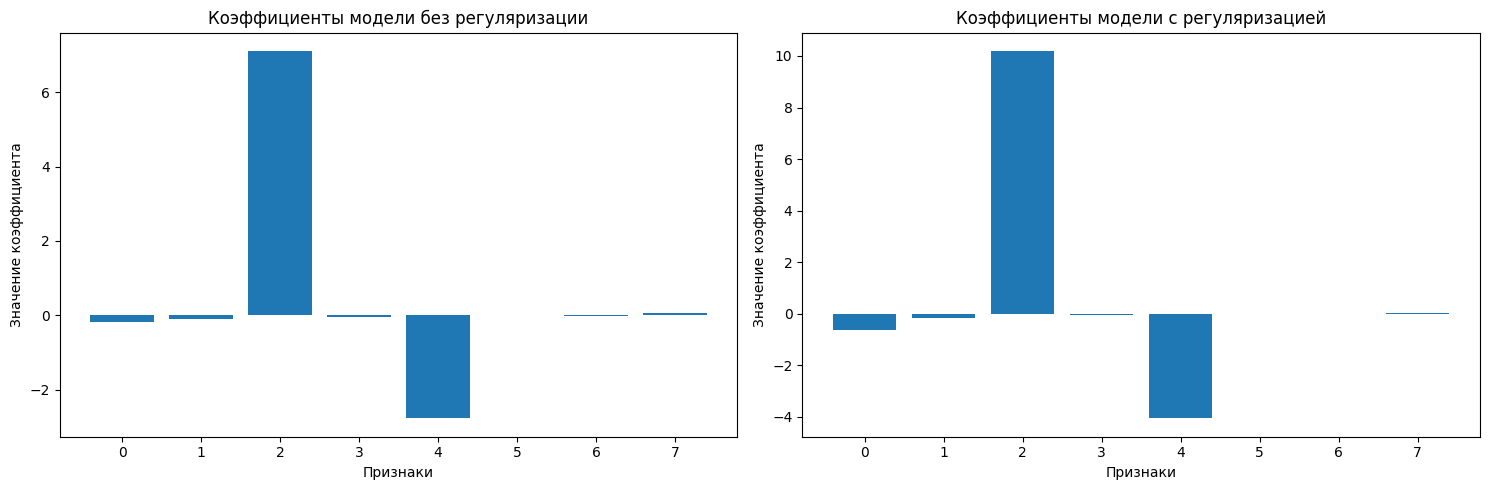

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [86]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.7785
Точность на тестовой выборке: 0.7799

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       135
           1       0.81      0.72      0.76       133

    accuracy                           0.78       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.78      0.78      0.78       268



Чуть стало лучше, но очень незначительные изменения

### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

k = 5
Точность на обучающей выборке: 0.7785
Точность на тестовой выборке: 0.7799

Классификационный отчет на тестовой выборке:

              precision    recall  f1-score   support

           0       0.75      0.84      0.79       135
           1       0.81      0.72      0.76       133

     accuracy                           0.78       268
    macro avg       0.78      0.78      0.78       268
    weighted avg       0.78      0.78      0.78       268


k = 7

Точность на обучающей выборке: 0.7785
Точность на тестовой выборке: 0.7799

Классификационный отчет на тестовой выборке:
             
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       135
           1       0.81      0.72      0.76       133

    accuracy                           0.78       268
    macro avg       0.78      0.78      0.78       268
    weighted avg       0.78      0.78      0.78       268

k = 4

Точность на обучающей выборке: 0.7785
Точность на тестовой выборке: 0.7799

Классификационный отчет на тестовой выборке:
            
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       135
           1       0.81      0.72      0.76       133

    accuracy                           0.78       268
    macro avg       0.78      0.78      0.78       268
    weighted avg       0.78      0.78      0.78       268

Возможно я что-то сделал не так, но у меня все показатели одинаковые были для разных К

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

Sequential Feature Selector (SFS) — это жадный алгоритм отбора признаков, который постепенно добавляет или удаляет признаки, чтобы найти наиболее релевантные для построения модели. Этот метод настраивается в двух вариантах: - Forward Selection (вперёд): начинается с пустого набора признаков и постепенно добавляет признаки, пока не будет достигнут желаемый размер набора. - Backward Selection (назад): начинается со всех признаков и поочередно удаляет менее значимые признаки.

SFS работает следующим образом: - Forward Selection: - Начинается с пустого набора признаков. - В каждой итерации добавляется один признак, который наилучшим образом улучшает производительность модели. - Этот процесс продолжается до тех пор, пока не будет достигнуто заранее заданное количество признаков. - Backward Selection: - Стартует с полного набора признаков. - На каждой итерации удаляется признак, который наименьшим образом влияет на производительность модели. - Процесс продолжается до тех пор, пока не будет достигнуто нужное количество признаков. Сравнение результатов с другими методами

    SelectKBest:
    Основан на статистической значимости признаков.
    Выбирает лучшие признаки на основе корреляции с целевой переменной.
    RFE (Recursive Feature Elimination):
    Пошагово удаляет менее важные признаки на основе модели.
    Результат для выборки 5 признаков показал такую же точность, что и
    SequentialFeatureSelector:
    Метод SFS жадно отбирает признаки по одному на основе их влияния на точность модели.
    Предварительные тесты показывают, что SFS часто приводит к выбору лучших признаков для конкретной модели, что может увеличить общую производительность.

In [111]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=6)
rfe.fit(X_processed, Y)

sfs = SequentialFeatureSelector(base_model, n_features_to_select=5)
sfs.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features_rfe = X_processed.columns[rfe.support_]
print("Отобранные признаки RFE:", selected_features_rfe)

# Получаем список отобранных признаков
selected_features_sfs = X_processed.columns[sfs.get_support()]
print("Отобранные признаки SFS:", selected_features_sfs)

Отобранные признаки RFE: Index(['bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_southwest'],
      dtype='object')
Отобранные признаки SFS: Index(['bmi', 'charges', 'smoker_yes', 'region_northwest', 'region_southeast'], dtype='object')


In [112]:
# Отбираем признаки
X_rfe = X_processed[selected_features_rfe]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)

Точность на обучающей выборке: 0.7785
Точность на тестовой выборке: 0.7799

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       135
           1       0.81      0.72      0.76       133

    accuracy                           0.78       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.78      0.78      0.78       268



In [113]:
# Отбираем признаки
X_sfs = X_processed[selected_features_sfs]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_sfs, Y)

Точность на обучающей выборке: 0.7822
Точность на тестовой выборке: 0.7836

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       135
           1       0.82      0.73      0.77       133

    accuracy                           0.78       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.79      0.78      0.78       268



Поигравшись с количеством признаков , я выяснил, что если брать их все, для обоих алгоритмов, то RFE  будет выдавать лучшие цифры, но если взять все минус 30%(3) то SFS начнет лидировать, хоть и незначительно, так как он выбирает только лучшие признаки, на основе их влияния на точность модели

## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [114]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [115]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [116]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [117]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


K-Fold Cross-Validation - Средняя точность: 0.772779361618872
Точности по каждому фолду: [0.8022388059701493, 0.746268656716418, 0.7910447761194029, 0.7303370786516854, 0.7940074906367042]


In [119]:
for n_splits in range(2, 10):
    print(f"n_splits = {n_splits}")
    k_fold_cross_validation(X_sfs.to_numpy(), Y.to_numpy(), n_splits=n_splits)

n_splits = 2
K-Fold Cross-Validation - Средняя точность: 0.7705530642750373
Точности по каждому фолду: [0.757847533632287, 0.7832585949177877]
n_splits = 3
K-Fold Cross-Validation - Средняя точность: 0.7772795216741405
Точности по каждому фолду: [0.7847533632286996, 0.7623318385650224, 0.7847533632286996]
n_splits = 4
K-Fold Cross-Validation - Средняя точность: 0.7780409330592547
Точности по каждому фолду: [0.7820895522388059, 0.755223880597015, 0.7904191616766467, 0.7844311377245509]
n_splits = 5
K-Fold Cross-Validation - Средняя точность: 0.7750293476438034
Точности по каждому фолду: [0.7985074626865671, 0.746268656716418, 0.7910447761194029, 0.7490636704119851, 0.7902621722846442]
n_splits = 6
K-Fold Cross-Validation - Средняя точность: 0.7750373692077729
Точности по каждому фолду: [0.7802690582959642, 0.7847533632286996, 0.7443946188340808, 0.7982062780269058, 0.7399103139013453, 0.8026905829596412]
n_splits = 7
K-Fold Cross-Validation - Средняя точность: 0.7802644290700574
Точност

### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [125]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())


ShuffleSplit Cross-Validation - Средняя точность: 0.7761194029850745
Точности по каждому разделению: [0.7761194029850746, 0.7966417910447762, 0.7686567164179104, 0.75, 0.789179104477612]


In [126]:
for n_splits in range(2, 10):
    print(f"n_splits = {n_splits}")
    shuffle_split_cross_validation(X_sfs.to_numpy(), Y.to_numpy(), n_splits=n_splits)

n_splits = 2
ShuffleSplit Cross-Validation - Средняя точность: 0.8003731343283582
Точности по каждому разделению: [0.8003731343283582, 0.8003731343283582]
n_splits = 3
ShuffleSplit Cross-Validation - Средняя точность: 0.7736318407960199
Точности по каждому разделению: [0.7593283582089553, 0.7817164179104478, 0.7798507462686567]
n_splits = 4
ShuffleSplit Cross-Validation - Средняя точность: 0.7518656716417911
Точности по каждому разделению: [0.7574626865671642, 0.7388059701492538, 0.7332089552238806, 0.7779850746268657]
n_splits = 5
ShuffleSplit Cross-Validation - Средняя точность: 0.7720149253731343
Точности по каждому разделению: [0.7779850746268657, 0.7854477611940298, 0.7649253731343284, 0.7705223880597015, 0.7611940298507462]
n_splits = 6
ShuffleSplit Cross-Validation - Средняя точность: 0.7795398009950248
Точности по каждому разделению: [0.792910447761194, 0.8097014925373134, 0.7761194029850746, 0.7742537313432836, 0.7910447761194029, 0.7332089552238806]
n_splits = 7
ShuffleSplit 

### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [124]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.8097014925373134
Точность на тестовых данных: 0.8037383177570093


In [122]:
for n_splits in range(2, 10):
    print(f"n_splits = {n_splits}")
    shuffle_split_cross_validation(X_sfs.to_numpy(), Y.to_numpy(), n_splits=n_splits)

n_splits = 2
ShuffleSplit Cross-Validation - Средняя точность: 0.7761194029850746
Точности по каждому разделению: [0.7742537313432836, 0.7779850746268657]
n_splits = 3
ShuffleSplit Cross-Validation - Средняя точность: 0.7786069651741294
Точности по каждому разделению: [0.7705223880597015, 0.7649253731343284, 0.8003731343283582]
n_splits = 4
ShuffleSplit Cross-Validation - Средняя точность: 0.771455223880597
Точности по каждому разделению: [0.7388059701492538, 0.7518656716417911, 0.8003731343283582, 0.7947761194029851]
n_splits = 5
ShuffleSplit Cross-Validation - Средняя точность: 0.7604477611940299
Точности по каждому разделению: [0.7779850746268657, 0.8059701492537313, 0.7425373134328358, 0.7574626865671642, 0.7182835820895522]
n_splits = 6
ShuffleSplit Cross-Validation - Средняя точность: 0.77363184079602
Точности по каждому разделению: [0.75, 0.7873134328358209, 0.789179104477612, 0.7294776119402985, 0.789179104477612, 0.7966417910447762]
n_splits = 7
ShuffleSplit Cross-Validation -

### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**

Несмотря на то , что метод Train-Test-Validation Split имеет самую большую базовую точность, так как мой датасет не очень большой, скорее всего он не подходит и где-то нас(или сам себя) обманывает,

ShuffleSplit Cross-Validation достойный метод, который в этом датасете будет работать лучше чем K-fold по моему мнению, так как выборка не такая уж и большая, и числа также на Shuffle лучше до 5 фолдов
